# Introduction

In this notebook we develop a MLP(multilayer perceptron) neural network for image classification. The data is Keras fashion dataset that has 60000 images of outfit items with 10 classes. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
fashion_mnist=keras.datasets.fashion_mnist
(x_train_full,y_train_full),(x_test,y_test)=fashion_mnist.load_data()

In [3]:
x_train_full.shape

(60000, 28, 28)

In [4]:
x_train_full.dtype

dtype('uint8')

The dataset is already split to test and train sets, but we still need to create a validation set. Also since we might be using gradient descent, we need to scale the input features. We divide the intensities by 255.0 to scale them to 0-1.

In [5]:
x_valid,x_train=x_train_full[:5000]/255.0,x_train_full[5000:]/255.0
y_valid,y_train=y_train_full[:5000],y_train_full[5000:]

In [6]:
x_train_full.shape

(60000, 28, 28)

In [7]:
class_names=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

Let's look at one of the images and check the class type for the image:

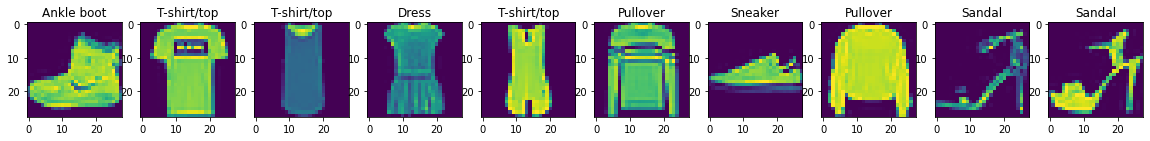

In [58]:
fig = plt.figure(figsize=(20, 7))
for i in range (1,11):
    fig.add_subplot(1,10, i)
    plt.imshow(x_train_full[i-1]) 
    plt.title(class_names[y_train_full[i-1]])

# Creating a model using the sequential API
Lets start with a simple MLP model with three hidden layers. The input layer passes the instances to the next layer. The input should be reshaped to a one dimentional array, and Flatten layer does this for us. For the hidden layers it is common practice to use ReLu. The number of hidden layers and neurons are selected randomly. Later we optimize these using grid search. The outer layer has 10 neurons (one per each class) and softmax for activation function (the probabilities between 0 and 1 and they all add up to 1).

In [32]:
model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dense(10,activation="softmax"))

We can display the model's layers with its parameters and shape using summery() method.

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 300)               235500    
                                                                 
 dense_8 (Dense)             (None, 300)               90300     
                                                                 
 dense_9 (Dense)             (None, 300)               90300     
                                                                 
 dense_10 (Dense)            (None, 10)                3010      
                                                                 
Total params: 419,110
Trainable params: 419,110
Non-trainable params: 0
_________________________________________________________________


We now call the compile() method to specify the loss function and optimizer to use. Since this is a classification task we chose sparse_categorical_crossentropy for loss and accuracy for metric:


In [34]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",metrics=["accuracy"])

## Training and evaluating the model
Now the model is ready to be trained. We simply need to call the fit() method:

In [35]:
history=model.fit(x_train,y_train,epochs=30,validation_data=(x_valid,y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7337 - accuracy: 0.7535 - val_loss: 0.5497 - val_accuracy: 0.8030
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4811 - accuracy: 0.8315 - val_loss: 0.4187 - val_accuracy: 0.8588
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4303 - accuracy: 0.8483 - val_loss: 0.4096 - val_accuracy: 0.8542
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3981 - accuracy: 0.8585 - val_loss: 0.3982 - val_accuracy: 0.8612
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3773 - accuracy: 0.8654 - val_loss: 0.3565 - val_accuracy: 0.8770
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3596 - accuracy: 0.8710 - val_loss: 0.3493 - val_accuracy: 0.8780
Epoch 7/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3457 - accuracy: 0.8745 - val_loss: 0.3633 - val_accuracy:

The fit() method returns a History object containing a dictionary (history.history) containing loss and extera metrics it measured at the end of each epoch on the training and validation sets. This dictionary can be used to plot learning curves:

(0.0, 1.0)

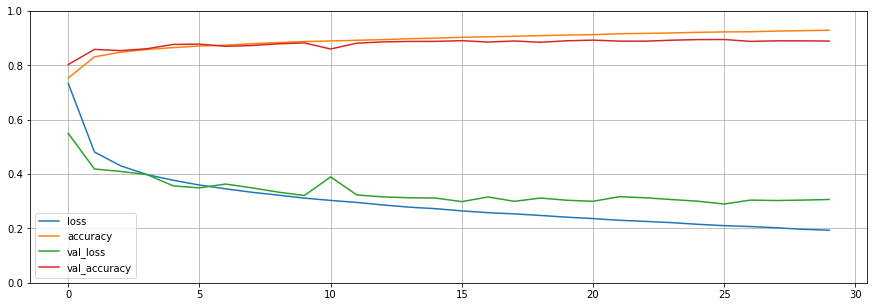

In [36]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(15,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

It seems that 15 epoch is reasonable for this model. Higher epochs seem to start overfitting the model as the val_accuracy and accuracy are diverging. 

# Hyperparameter Tuning 
The model we defined above was random. We need to tune the model for hyperparameters. We can use the scikeras package for hyperparameter tuning. Hyperparameter tuning could be computationally expensive, therefore here we use search over a small grid with few hyperparameters. The scikeras library provides a convenient wrapper for deep learning models to be used as classification or regression estimators in scikit-learn.

In [16]:
import scikeras
from scikeras.wrappers import KerasClassifier
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [18]:
def build_model(n_hidden=1, n_neurons=100,learning_rate=0.01,input_shape=[28,28],dropout=0.5):
    model1=keras.models.Sequential()
    model1.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model1.add(keras.layers.Dense(n_neurons,activation="relu"))
        model1.add(keras.layers.Dropout(dropout))
    model1.add(keras.layers.Dense(10,activation="softmax"))
    model1.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    return model1

Now we wrapp our build_model in KerasClassifier so we can use it in the sklearn model selection later.

In [19]:
clf = KerasClassifier(
    model=build_model,
    n_hidden=4,
    n_neurons=200,
    optimizer="Adam",
    dropout=0.5,
    learning_rate=0.1,
   )

Now we can use grid search over a range of hyperparameters to find an optimized combination. This task might be computationally expensive, so we only try a small set of parameters.

In [31]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_hidden': [2,3],
    'n_neurons': [200,300],
    'optimizer': ['SGD','Adam'],
    'learning_rate': [0.1,0.2],
    'dropout': [0.5],
}
# uncomment these lines for grid search
#grid = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, verbose=True)
#grid.fit(x_train,y_train,epochs=15,validation_data=(x_valid,y_valid))


In [38]:
print('best score from the grid search is',round(grid.best_score_,3),' and best hyperparameters for this model are:', grid.best_params_)

best score from the grid search is 0.859  and best hyperparameters for this model are: {'dropout': 0.5, 'learning_rate': 0.1, 'n_hidden': 2, 'n_neurons': 300, 'optimizer': 'SGD'}


We can save the best estimated model in the grid search as our final model and use it for testing.

In [39]:
model_final=grid.best_estimator_

In [40]:
final_prediction=model_final.predict(x_test)

313/313 [==============================] - 0s 1ms/step


In [41]:
import sklearn
final_accuracy=sklearn.metrics.accuracy_score(y_test,final_prediction)
final_accuracy

0.8452

The test accuracy of the model is 0.8452. Lets look at some of the predictions.

In [61]:
x_new=x_test[10:20]
y_pred=model_final.predict(x_new)

1/1 [==============================] - 0s 17ms/step


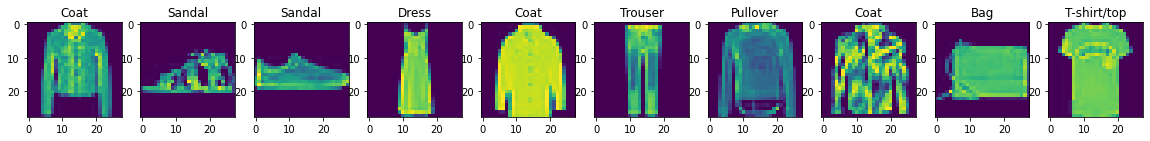

In [62]:
fig = plt.figure(figsize=(20, 7))
for i in range (1,11):
    fig.add_subplot(1,10, i)
    plt.imshow(x_new[i-1]) 
    plt.title(class_names[y_pred[i-1]])
 

It seems that the model is having trouble diffrenciating sandals from sneakers. The model is doing a good job classifying other images.

# Conclusion
 A MLP classifier was developed for classifying fashion item images from Keras dataset.The hyperparameter tuning was done using grid search with these parameters: 'dropout': 0.5, 'learning_rate': 0.1, 'n_hidden': 2, 'n_neurons': 300, 'optimizer': 'SGD'.
 The test accuracy was 0.859 and the model does a decent job identifying most of classes. However it seems there are misclassification between sandals and sneekers and that might be the reason for low accuracy.